#  TOP-10 hubs prediction 

Выберем для предсказания только самые популярные хабы (10 самых часто встречающихся в нашем датасете) и попробуем применить multi-label классификацию.

Автор: Карнакова Ксения

In [182]:
import pandas as pd
import numpy as np
import re
import pickle
from pymystem3 import Mystem
from sklearn.model_selection import train_test_split
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import eli5

Загружаем датасет:

In [35]:
habr_df = pd.read_parquet('data/habrdf.parquet')

Функции для предобработки текста:

In [3]:
mystem = Mystem()

stopwords_russian = stopwords.words('russian')
stopwords_english = stopwords.words('english')

def remove_tags(text):
    '''
    удаляет теги html
    '''
    text = re.sub(r'<[^>]*>', "", text, flags=re.MULTILINE)
    return text


def remove_http(text):
    """ 
    удаляет ссылки и e-mail
    """
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', " ", text, flags=re.MULTILINE) 
    text = re.sub(r"([\w+-]+[\w.+-]*@[a-zA-Z0-9-]+\.[a-zA-Z0-9-]+)", " ", text, flags=re.MULTILINE)
    return text


def remove_space(text):
    """ 
    удаляет разделители и лишние пробелы
    """
    text = re.sub(r'[\s\n\t]', " ", text)
    text = re.sub(r'\s{2,}', " ", text)
    return text


def lemmatize_text(text):
    '''
      Лемматизация текста
      если слова нет в списке стоп-слов,
      слово длиннее двух символов
      состоит только из букв/ только из букв и есть тире
    '''
    text_tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in text_tokens if token not in (stopwords_russian or stopwords_english)
              and len(token) > 2 \
              and (token.isalpha() or ((token.split('-')[0]).isalpha()))]
    return " ".join(tokens)


In [4]:
def preprocessing_text(text):
    text = remove_tags(text)
    text = remove_http(text)
    text = remove_space(text)
    text = lemmatize_text(text)
    return text

In [5]:
hubs_count = pd.Series([i for j in habr_df['hubs'].values for i in j]).value_counts()
hubs_dict = dict(zip(hubs_count.index, range(len(hubs_count.index))))
dict_hubs = {j: i for i, j in hubs_dict.items()}

Топ-10 самых частовстречающихся хабов в публикациях:

In [6]:
hubs_count[:10]

infosecurity         13694
programming          12993
it-infrastructure     7377
machine_learning      6512
webdev                6094
javascript            5572
python                5450
sys_admin             5314
hr_management         4976
open_source           4602
Name: count, dtype: int64

Дальше выберем из датасета только статьи, которые содержат статьи с этими хабами, и будем предсказывать эти 10 хабов.

In [7]:
hubs_count.index[:10]

Index(['infosecurity', 'programming', 'it-infrastructure', 'machine_learning',
       'webdev', 'javascript', 'python', 'sys_admin', 'hr_management',
       'open_source'],
      dtype='object')

In [8]:
# для каждой статьи подсчитаем сколько в ней хабов из топ-10
habrtop10_dictionary = {}
for num in habr_df.index:
    count = 0
    for el in hubs_count.index[:10]:        
        if el in habr_df['hubs'].values[num]:
            count+=1
    habrtop10_dictionary[num] = count

In [9]:
# сколько в статьях хабов из топ-10
habrtop10_count = pd.Series(habrtop10_dictionary).value_counts()
habrtop10_count

0    57087
1    45108
2    11130
3     1644
4       71
Name: count, dtype: int64

In [10]:
for i in range(len(habrtop10_count)):
    print(f'В датасете {habrtop10_count[i]} статей с {habrtop10_count.index[i]} хабами из топ-10')

В датасете 57087 статей с 0 хабами из топ-10
В датасете 45108 статей с 1 хабами из топ-10
В датасете 11130 статей с 2 хабами из топ-10
В датасете 1644 статей с 3 хабами из топ-10
В датасете 71 статей с 4 хабами из топ-10


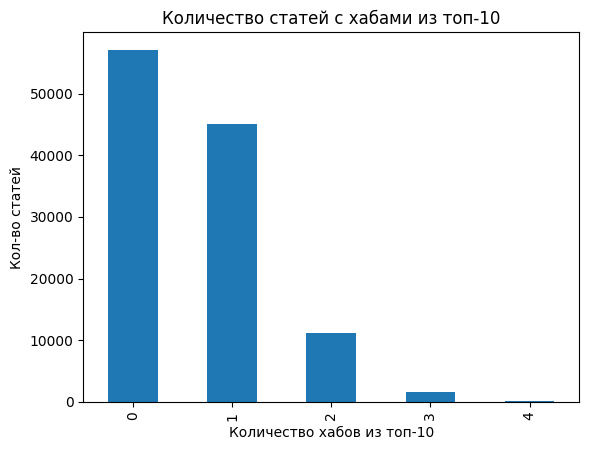

In [11]:
pd.Series(habrtop10_dictionary).value_counts().plot(
    kind='bar', 
    title="Количество статей с хабами из топ-10", 
    xlabel="Количество хабов из топ-10",
    ylabel="Кол-во статей"
)

plt.show()

In [12]:
# индекс в датафрейме статей, у которых в хабах указано 1 хаб или больше из топ-10

index_habr_top10 = [k for k,v in habrtop10_dictionary.items() if v>=1]

In [13]:
print(f'Количество статей, в каждой из которых указан 1 хаб или больше из топ-10: {len(index_habr_top10)}')

Количество статей, в каждой из которых указан 1 хаб или больше из топ-10: 57953


In [14]:
habr_df_top10 = habr_df.copy()
habr_df_top10 = habr_df_top10.iloc[index_habr_top10]

In [15]:
pd.options.mode.chained_assignment = None

In [16]:
# оставим в списке хабов датафрейма только хабы из топ10
for num in habr_df_top10.index:
    temp = []
    for hub in habr_df_top10.hubs[num]:
        if hub in hubs_count.index[:10]:
            temp.append(hub)
    habr_df_top10.hubs[num] = temp

In [17]:
habr_df_top10[['id', 'lemmatized_text', 'hubs']]

,id,lemmatized_text,hubs
0,310000,основной хранилище метрика являться cassandra ...,[sys_admin]
1,310002,война гипервизор дело непрерывный наверное дей...,[it-infrastructure]
3,310008,современный nfc технология нынешний вид появля...,[infosecurity]
4,310014,год назад openjdk создавать новый проект кодов...,[programming]
5,310022,последний несколько год английский язык появля...,[it-infrastructure]
...,...,...,...
115031,773120,ноябрь год профильный сми сообщать microsoft в...,"[infosecurity, hr_management]"
115032,773122,весь мир говорить страна датацентр del complex...,[machine_learning]
115034,773126,когда-либо работать рекомендательный система з...,"[python, machine_learning]"
115035,773128,центр биометрический технология цбт эксперт из...,[infosecurity]


In [32]:
habr_df_top10.to_parquet('data/top10hubs/habr_df_top10.parquet', index=False)

Поделим получившийся датасет на трейн и тест и при помощи tf-idf векторизируем тексты статей.

In [18]:
df_train, df_test = train_test_split(habr_df_top10, test_size=0.3, random_state=42)

### Предобработка данных к применению multilabel-классификации: TfidfVectorizer, MultiLabelBinarizer

In [19]:
%%time
STOPWORDS = nltk.corpus.stopwords.words("russian")
tfidfvectorizer = TfidfVectorizer(analyzer='word', min_df=5, max_df=0.95, stop_words=STOPWORDS)
df_train_tfidf = tfidfvectorizer.fit_transform(df_train['lemmatized_text'].values)
df_test_tfidf = tfidfvectorizer.transform(df_test['lemmatized_text'].values)

CPU times: user 51.9 s, sys: 3.42 s, total: 55.3 s
Wall time: 1min 2s


In [20]:
len_vec = df_train_tfidf.shape[1]
print(f'Длина вектора: {len_vec}')

Длина вектора: 77048


In [27]:
with open('data/top10hubs/TfidfVectorizer.pkl', 'wb') as file:
    pickle.dump(tfidfvectorizer, file)

In [21]:
mlb = MultiLabelBinarizer(classes=hubs_count.index[:10].values)
y_train = mlb.fit_transform(df_train['hubs'])
y_test = mlb.fit_transform(df_test['hubs'])

In [138]:
with open('data/top10hubs/MultiLabelBinarizer.pkl', 'wb') as file:
    pickle.dump(mlb, file)

### Ridge Classifier

In [81]:
%%time
clf = RidgeClassifier().fit(df_train_tfidf, y_train)
pred = clf.predict(df_test_tfidf)

CPU times: user 1min 4s, sys: 11.2 s, total: 1min 15s
Wall time: 46.9 s


In [161]:
with open('data/top10hubs/RidgeClassifier.pkl', 'wb') as file:
    pickle.dump(clf, file)

In [82]:
print(classification_report(y_test, pred, zero_division=0, target_names=mlb.classes_))

                   precision    recall  f1-score   support

     infosecurity       0.92      0.81      0.86      4080
      programming       0.78      0.55      0.65      3909
it-infrastructure       0.78      0.47      0.59      2222
 machine_learning       0.90      0.74      0.81      1928
           webdev       0.77      0.45      0.57      1832
       javascript       0.87      0.70      0.77      1677
           python       0.89      0.62      0.73      1612
        sys_admin       0.76      0.47      0.58      1656
    hr_management       0.91      0.73      0.81      1467
      open_source       0.84      0.35      0.49      1360

        micro avg       0.85      0.61      0.71     21743
        macro avg       0.84      0.59      0.69     21743
     weighted avg       0.84      0.61      0.70     21743
      samples avg       0.67      0.64      0.64     21743



In [90]:
eli5.show_weights(estimator=clf,
                  feature_names= list(tfidfvectorizer.get_feature_names_out()),
                  target_names=mlb.classes_,
                  top=(15, 5))

In [61]:
%%time

parameters = {
    'alpha':[0.01, 0.1, 1, 10],
}

gsc = GridSearchCV(RidgeClassifier(), parameters, verbose=3, cv=3, scoring='f1_micro', n_jobs=-1)
gsc.fit(df_train_tfidf, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
CPU times: user 1min 4s, sys: 12.4 s, total: 1min 17s
Wall time: 9min 26s


GridSearchCV(cv=3, estimator=RidgeClassifier(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1, 10]}, scoring='f1_micro',
             verbose=3)

In [62]:
print(gsc.best_params_)
bestRC = gsc.best_estimator_
bestRC.fit(df_train_tfidf, y_train)
y_pred = bestRC.predict(df_test_tfidf)
print(classification_report(y_test, y_pred, zero_division=0, target_names=mlb.classes_))

{'alpha': 1}
                   precision    recall  f1-score   support

     infosecurity       0.92      0.81      0.86      4080
      programming       0.78      0.55      0.65      3909
it-infrastructure       0.78      0.47      0.59      2222
 machine_learning       0.90      0.74      0.81      1928
           webdev       0.77      0.45      0.57      1832
       javascript       0.87      0.70      0.77      1677
           python       0.89      0.62      0.73      1612
        sys_admin       0.76      0.47      0.58      1656
    hr_management       0.91      0.73      0.81      1467
      open_source       0.84      0.35      0.49      1360

        micro avg       0.85      0.61      0.71     21743
        macro avg       0.84      0.59      0.69     21743
     weighted avg       0.84      0.61      0.70     21743
      samples avg       0.67      0.64      0.64     21743



### OneVsRestClassifier(LinearSVC())

In [24]:
%%time

svc = OneVsRestClassifier(LinearSVC())
svc.fit(df_train_tfidf, y_train)
y_pred = svc.predict(df_test_tfidf)
print(classification_report(y_test, y_pred, zero_division=0, target_names=mlb.classes_))

                   precision    recall  f1-score   support

     infosecurity       0.91      0.84      0.87      4080
      programming       0.72      0.59      0.65      3909
it-infrastructure       0.73      0.53      0.62      2222
 machine_learning       0.89      0.80      0.84      1928
           webdev       0.72      0.50      0.59      1832
       javascript       0.85      0.75      0.80      1677
           python       0.85      0.70      0.77      1612
        sys_admin       0.71      0.54      0.61      1656
    hr_management       0.89      0.79      0.84      1467
      open_source       0.76      0.41      0.54      1360

        micro avg       0.81      0.66      0.73     21743
        macro avg       0.80      0.65      0.71     21743
     weighted avg       0.81      0.66      0.72     21743
      samples avg       0.71      0.69      0.68     21743

CPU times: user 13.1 s, sys: 1.04 s, total: 14.1 s
Wall time: 14.7 s


In [25]:
with open('data/top10hubs/OneVsRestClassifierLinearSVC.pkl', 'wb') as file:
    pickle.dump(svc, file)

In [26]:
%%time

svc1 = OneVsRestClassifier(LinearSVC(C=10))
svc1.fit(df_train_tfidf, y_train)
y_pred = svc1.predict(df_test_tfidf)
print(classification_report(y_test, y_pred, zero_division=0, target_names=mlb.classes_))

                   precision    recall  f1-score   support

     infosecurity       0.88      0.83      0.85      4080
      programming       0.62      0.60      0.61      3909
it-infrastructure       0.61      0.55      0.58      2222
 machine_learning       0.85      0.79      0.82      1928
           webdev       0.64      0.54      0.58      1832
       javascript       0.81      0.75      0.78      1677
           python       0.80      0.70      0.75      1612
        sys_admin       0.63      0.57      0.60      1656
    hr_management       0.85      0.80      0.82      1467
      open_source       0.60      0.47      0.53      1360

        micro avg       0.73      0.67      0.70     21743
        macro avg       0.73      0.66      0.69     21743
     weighted avg       0.73      0.67      0.70     21743
      samples avg       0.68      0.70      0.67     21743

CPU times: user 53.7 s, sys: 1.22 s, total: 54.9 s
Wall time: 56.1 s


In [29]:
with open('data/top10hubs/OneVsRestClassifierLinearSVC2.pkl', 'wb') as file:
    pickle.dump(svc1, file)

In [28]:
%%time

svc2 = OneVsRestClassifier(LinearSVC(C=0.1))
svc2.fit(df_train_tfidf, y_train)
y_pred = svc2.predict(df_test_tfidf)
print(classification_report(y_test, y_pred, zero_division=0, target_names=mlb.classes_))

                   precision    recall  f1-score   support

     infosecurity       0.92      0.80      0.86      4080
      programming       0.79      0.51      0.62      3909
it-infrastructure       0.80      0.42      0.55      2222
 machine_learning       0.90      0.74      0.81      1928
           webdev       0.77      0.41      0.53      1832
       javascript       0.88      0.69      0.77      1677
           python       0.88      0.61      0.72      1612
        sys_admin       0.77      0.43      0.55      1656
    hr_management       0.90      0.74      0.82      1467
      open_source       0.86      0.29      0.43      1360

        micro avg       0.86      0.58      0.70     21743
        macro avg       0.85      0.56      0.67     21743
     weighted avg       0.85      0.58      0.68     21743
      samples avg       0.66      0.61      0.62     21743

CPU times: user 6.93 s, sys: 973 ms, total: 7.9 s
Wall time: 8.19 s


In [31]:
with open('data/top10hubs/OneVsRestClassifierLinearSVC3.pkl', 'wb') as file:
    pickle.dump(svc2, file)

In [32]:
%%time

svc3 = OneVsRestClassifier(LinearSVC(C=0.5))
svc3.fit(df_train_tfidf, y_train)
y_pred = svc3.predict(df_test_tfidf)
print(classification_report(y_test, y_pred, zero_division=0, target_names=mlb.classes_))

                   precision    recall  f1-score   support

     infosecurity       0.92      0.83      0.87      4080
      programming       0.75      0.58      0.65      3909
it-infrastructure       0.76      0.51      0.61      2222
 machine_learning       0.90      0.78      0.84      1928
           webdev       0.75      0.49      0.59      1832
       javascript       0.86      0.74      0.79      1677
           python       0.86      0.69      0.76      1612
        sys_admin       0.75      0.52      0.61      1656
    hr_management       0.90      0.79      0.84      1467
      open_source       0.80      0.39      0.52      1360

        micro avg       0.83      0.65      0.73     21743
        macro avg       0.82      0.63      0.71     21743
     weighted avg       0.82      0.65      0.72     21743
      samples avg       0.70      0.68      0.67     21743

CPU times: user 9.68 s, sys: 1 s, total: 10.7 s
Wall time: 11.2 s


In [33]:
with open('data/top10hubs/OneVsRestClassifierLinearSVC4.pkl', 'wb') as file:
    pickle.dump(svc3, file)

Самые высокие значения метрик `precision`, `recall` и `F1` при `C=1` и `C=0.5`: в первом случае выше `precision`, во втором `recall`, `F1` одинакова у двух моделей. 

###  OneVsRestClassifier(LogisticRegression())

In [35]:
%%time

clf2 = OneVsRestClassifier(LogisticRegression())
clf2.fit(df_train_tfidf, y_train)

CPU times: user 1min 41s, sys: 17.4 s, total: 1min 59s
Wall time: 1min 4s


OneVsRestClassifier(estimator=LogisticRegression())

In [36]:
pred2 = clf2.predict(df_test_tfidf)

In [37]:
print(classification_report(y_test, pred2, zero_division=0, target_names=mlb.classes_))

                   precision    recall  f1-score   support

     infosecurity       0.92      0.80      0.85      4080
      programming       0.78      0.52      0.63      3909
it-infrastructure       0.78      0.44      0.56      2222
 machine_learning       0.90      0.72      0.80      1928
           webdev       0.75      0.41      0.53      1832
       javascript       0.87      0.67      0.76      1677
           python       0.88      0.60      0.71      1612
        sys_admin       0.76      0.43      0.55      1656
    hr_management       0.90      0.72      0.80      1467
      open_source       0.84      0.30      0.44      1360

        micro avg       0.85      0.58      0.69     21743
        macro avg       0.84      0.56      0.66     21743
     weighted avg       0.84      0.58      0.68     21743
      samples avg       0.65      0.61      0.62     21743



In [44]:
pickle.dump(clf2, open('data/top10hubs/OneVsRestClassifierLogReg.pkl', 'wb'))

In [51]:
%%time

clf3 = OneVsRestClassifier(LogisticRegression(C=10, max_iter=750))
clf3.fit(df_train_tfidf, y_train)
pred3 = clf3.predict(df_test_tfidf)
print(classification_report(y_test, pred3, zero_division=0, target_names=mlb.classes_))

                   precision    recall  f1-score   support

     infosecurity       0.91      0.83      0.87      4080
      programming       0.72      0.59      0.65      3909
it-infrastructure       0.73      0.53      0.61      2222
 machine_learning       0.89      0.78      0.83      1928
           webdev       0.72      0.50      0.59      1832
       javascript       0.85      0.73      0.78      1677
           python       0.85      0.68      0.76      1612
        sys_admin       0.72      0.53      0.61      1656
    hr_management       0.89      0.78      0.83      1467
      open_source       0.76      0.42      0.54      1360

        micro avg       0.81      0.65      0.72     21743
        macro avg       0.81      0.64      0.71     21743
     weighted avg       0.81      0.65      0.72     21743
      samples avg       0.70      0.68      0.67     21743

CPU times: user 4min, sys: 39.8 s, total: 4min 40s
Wall time: 2min 23s


In [52]:
pickle.dump(clf3, open('data/top10hubs/OneVsRestClassifierLogReg2.pkl', 'wb'))

In [57]:
%%time

clf4 = OneVsRestClassifier(LogisticRegression(C=100, max_iter=750))
clf4.fit(df_train_tfidf, y_train)
pred4 = clf4.predict(df_test_tfidf)
print(classification_report(y_test, pred4, zero_division=0, target_names=mlb.classes_))

                   precision    recall  f1-score   support

     infosecurity       0.90      0.83      0.86      4080
      programming       0.65      0.60      0.62      3909
it-infrastructure       0.66      0.55      0.60      2222
 machine_learning       0.87      0.79      0.83      1928
           webdev       0.68      0.52      0.59      1832
       javascript       0.84      0.74      0.78      1677
           python       0.83      0.69      0.76      1612
        sys_admin       0.68      0.55      0.61      1656
    hr_management       0.88      0.79      0.83      1467
      open_source       0.67      0.45      0.54      1360

        micro avg       0.77      0.66      0.71     21743
        macro avg       0.77      0.65      0.70     21743
     weighted avg       0.77      0.66      0.71     21743
      samples avg       0.69      0.69      0.67     21743

CPU times: user 8min 7s, sys: 1min 19s, total: 9min 26s
Wall time: 4min 46s


In [58]:
pickle.dump(clf4, open('data/top10hubs/OneVsRestClassifierLogReg3.pkl', 'wb'))

In [59]:
 %%time

clf5 = OneVsRestClassifier(LogisticRegression(C=50, max_iter=750))
clf5.fit(df_train_tfidf, y_train)
pred5 = clf5.predict(df_test_tfidf)
print(classification_report(y_test, pred5, zero_division=0, target_names=mlb.classes_))

                   precision    recall  f1-score   support

     infosecurity       0.90      0.83      0.86      4080
      programming       0.67      0.60      0.63      3909
it-infrastructure       0.67      0.55      0.60      2222
 machine_learning       0.88      0.78      0.83      1928
           webdev       0.69      0.52      0.60      1832
       javascript       0.85      0.73      0.78      1677
           python       0.84      0.69      0.75      1612
        sys_admin       0.69      0.55      0.61      1656
    hr_management       0.88      0.79      0.84      1467
      open_source       0.69      0.44      0.54      1360

        micro avg       0.78      0.66      0.72     21743
        macro avg       0.78      0.65      0.70     21743
     weighted avg       0.78      0.66      0.71     21743
      samples avg       0.69      0.69      0.67     21743

CPU times: user 6min 47s, sys: 1min 7s, total: 7min 55s
Wall time: 4min 2s


In [60]:
pickle.dump(clf5, open('data/top10hubs/OneVsRestClassifierLogReg4.pkl', 'wb'))

Мы применили `Ridge Classifier`, `One-vs-Rest` классификацию для `LinearSVC` и `LogisticRegression`. Метрики всех моделей значительно выше, чем в экспериментах по предсказанию большего количества хабов в предыдущем ноутбуке (`ML_hubs_prediction.ipynb`)

## Попробуем предсказать по тексту хабы

In [171]:
def predict_item(item: str, model, multilabelbinarizer) -> list:
        preprocessed_item = preprocessing_text(item)
        preprocessed_item = tfidfvectorizer.transform([preprocessed_item])
        predicted_labels = model.predict(preprocessed_item)
        return multilabelbinarizer.classes[predicted_labels[0].astype(bool)]

Выведем предсказанные и реальные хабы для конкретных статей:

In [172]:
print(f'предсказанные хабы: {predict_item(df_test.lemmatized_text.iloc[33], svc3, mlb)}')
print(f'реальные хабы: {df_test.hubs.iloc[33]}')

предсказанные хабы: ['python']
реальные хабы: ['python', 'programming']


In [173]:
print(f'предсказанные хабы: {predict_item(df_test.lemmatized_text.iloc[1111], svc3, mlb)}')
print(f'реальные хабы: {df_test.hubs.iloc[1111]}')

предсказанные хабы: ['hr_management']
реальные хабы: ['hr_management']


In [174]:
print(f'предсказанные хабы: {predict_item(df_test.lemmatized_text.iloc[333], svc3, mlb)}')
print(f'реальные хабы: {df_test.hubs.iloc[333]}')

предсказанные хабы: ['it-infrastructure' 'sys_admin']
реальные хабы: ['sys_admin']


In [175]:
print(f'предсказанные хабы: {predict_item(df_test.lemmatized_text.iloc[346], svc3, mlb)}')
print(f'реальные хабы: {df_test.hubs.iloc[346]}')

предсказанные хабы: ['programming']
реальные хабы: ['python', 'programming']


In [176]:
def predict_items(items: pd.DataFrame, model, multilabelbinarizer) -> pd.DataFrame:
    preprocessed_items = items['text'].apply(preprocessing_text)
    preprocessed_items = tfidfvectorizer.transform(preprocessed_items)
    predicted_labels = model.predict(preprocessed_items)
    items['prediction'] = pd.Series()
    for i in range(len(predicted_labels)):
        if np.any(predicted_labels[i]):
            items['prediction'].iloc[i] = list(multilabelbinarizer.classes[predicted_labels[i].astype(bool)])
        else:
            items['prediction'].iloc[i] = [None]
    return items

In [192]:
# создадим датафрейм из текстов для предсказания хабов
test1 = pd.DataFrame()
test1['text'] = df_test["lemmatized_text"][325:350]
test1

,text
23976,информационный безопасность дисциплина набират...
11960,принудительно вставлять иллюстрация каждый онл...
35556,наверняка слышать выражение багхантинг уверенн...
57006,обзор библиотека lens эксперимент котик данные...
106512,привет звать иван nubes отвечать направление в...
24427,просыпаться сиять солнце щебетать птичка мир н...
41921,статья написать ответ статья собеседование дод...
67335,национальный институт стандарт технология сша ...
15422,существовать различный метод организация центр...
82810,первый часть анализ аудиодать рассматривать ха...


In [193]:
predict_items(test1, svc3, mlb)

,text,prediction
23976,информационный безопасность дисциплина набират...,[infosecurity]
11960,принудительно вставлять иллюстрация каждый онл...,[None]
35556,наверняка слышать выражение багхантинг уверенн...,[infosecurity]
57006,обзор библиотека lens эксперимент котик данные...,[javascript]
106512,привет звать иван nubes отвечать направление в...,[it-infrastructure]
24427,просыпаться сиять солнце щебетать птичка мир н...,"[webdev, javascript]"
41921,статья написать ответ статья собеседование дод...,[hr_management]
67335,национальный институт стандарт технология сша ...,[infosecurity]
15422,существовать различный метод организация центр...,"[it-infrastructure, sys_admin]"
82810,первый часть анализ аудиодать рассматривать ха...,"[programming, machine_learning, python]"


In [194]:
# так как мы взяли тексты из тестового датасета, то у нас есть реальные хабы для этих текстов
test1['real_hubs'] = df_test["hubs"][325:350]

In [195]:
test1

,text,prediction,real_hubs
23976,информационный безопасность дисциплина набират...,[infosecurity],[infosecurity]
11960,принудительно вставлять иллюстрация каждый онл...,[None],[webdev]
35556,наверняка слышать выражение багхантинг уверенн...,[infosecurity],"[infosecurity, open_source, programming]"
57006,обзор библиотека lens эксперимент котик данные...,[javascript],[javascript]
106512,привет звать иван nubes отвечать направление в...,[it-infrastructure],[it-infrastructure]
24427,просыпаться сиять солнце щебетать птичка мир н...,"[webdev, javascript]","[webdev, javascript]"
41921,статья написать ответ статья собеседование дод...,[hr_management],[hr_management]
67335,национальный институт стандарт технология сша ...,[infosecurity],[infosecurity]
15422,существовать различный метод организация центр...,"[it-infrastructure, sys_admin]",[sys_admin]
82810,первый часть анализ аудиодать рассматривать ха...,"[programming, machine_learning, python]","[python, programming, machine_learning]"
